# MLP : Batch Normalization 

## Part 5 : Refactor
---
Normalize the output of a linear before it goes to activation.

This is possible as all the normalization does is get mean and standard deviation, and divide them to normalize it. This is completely differntiable and hence works for backprop


**Implemented**

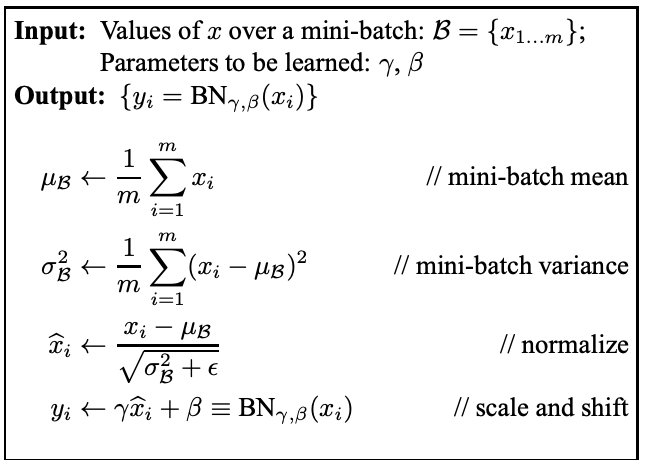

---

Kaiming init Paper : https://arxiv.org/pdf/1502.01852.pdf

BatchNorm Paper : https://arxiv.org/pdf/1502.03167.pdf

In [1]:
from typing import List
import random

In [2]:
import torch
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [3]:
import torch.nn.functional as F

## 1. Data Gathering

In [4]:
words = open('data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

## 2. Data Pre-Processing

In [6]:
START = END = '.'
CHARS = sorted(list(set(''.join(words))) + [START])

stoi = {char:idx for idx, char in enumerate(CHARS)}
itos = {i:s for s, i in stoi.items()}

In [7]:
print(f"\n{CHARS=}")
print(f"\n{stoi=}")
print(f"\n{itos=}")


CHARS=['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

stoi={'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}

itos={0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


### 2.1 NGrams Split

In [8]:
def get_ngrams(words: List[str], ngrams=3, debug=False):
    X, Y = list(), list()
    
    for word in words:
        if debug: print(f"-- {word} --")
        context_idxs = [stoi[START]] * (ngrams-1)
        
        for char in word+END:
            pred_idx = stoi[char]
            Y.append(pred_idx)
            X.append(context_idxs)
            
            if debug: print(f"{''.join(itos[i] for i in context_idxs)} {itos[pred_idx]}")
            context_idxs = context_idxs[1:] + [pred_idx]
            
    return torch.tensor(X), torch.tensor(Y)

In [9]:
NGRAMS = 4
CONTEXT_SIZE = NGRAMS - 1

#### 2.1.1 Train Test split

In [10]:
def split_data(data: List, ratio: float = 0.8):
    split_idx = int(ratio*len(data))
    return data[:split_idx], data[split_idx:]


In [11]:
random.shuffle(words)

train_words, test_words = split_data(data=words, ratio=0.8)
val_words, test_words = split_data(data=test_words, ratio=0.5)

assert len(words) == len(train_words) + len(val_words) + len(test_words)
len(train_words), len(val_words), len(test_words)

(25626, 3203, 3204)

In [12]:
# Complete Dataset

X_train, Y_train = get_ngrams(words=train_words, ngrams=NGRAMS, debug=False)
X_val, Y_val = get_ngrams(words=val_words, ngrams=NGRAMS, debug=False)
X_test, Y_test = get_ngrams(words=test_words, ngrams=NGRAMS, debug=False)


X_train.shape, Y_train.shape

(torch.Size([182761, 3]), torch.Size([182761]))

## 3. MLP

### 3.1 Architecture


#### 3.1.1 Linear Layer

Just like [torch.nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

In [13]:
class Linear:
    
    def __init__(self, in_features, out_features, bias=True, device=None):
        
        self.weight = torch.randn((in_features, out_features), generator=g) / in_features**0.5
        self.bias = torch.zeros(out_features) if bias else None
        
    def __call__(self, x):
        
        self.out = x @ self.weight
        if self.bias is not None: self.out += self.bias
        return self.out
    
    def parameters(self):
 
        return [self.weight] + ([self.bias] if self.bias is not None else [])
    
    def to(self, device):
        self.weight = self.weight.detach().to(device)
        self.bias = self.bias.detach().to(device) if self.bias is not None else None


#### 3.1.2 TanH layer

In [14]:
class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
    def to(self, device):
        pass

#### 3.1.3 BatchNorm1d Layer

Just like [torch.nn.BatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)

In [15]:
class BatchNorm1d:
    
    def __init__(self, num_features, eps=1e-05, momentum=0.001, device=None):
        
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # Trainable Params
        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)
        
        # Non-Trainable Params
        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)
        
    def __call__(self, x):
        
        # Get Non Trainables
        if self.training: 
            x_mean = x.mean(0, keepdims=True) # Mean of the batch
            x_var = x.var(0, keepdims=True) # Var of the batch
            
        else:
            x_mean = self.running_mean
            x_var = self.running_var
           
        # Forward
        normalized_x = (x - x_mean) / torch.sqrt(x_var + self.eps)
        self.out = self.gamma * normalized_x + self.beta
        
        # Update Non Trainables
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var
                
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
    def to(self, device):
        self.gamma = self.gamma.detach().to(device)
        self.beta = self.beta.detach().to(device) 
        self.running_mean = self.running_mean.detach().to(device) 
        self.running_var = self.running_var.detach().to(device) 

#### 3.1.4 Neural Network

In [16]:
class MLP:
    
    def __init__(self, vocab_size, block_size, n_embd, n_hidden):
        self._device = 'cpu'

        # Embeding Layer
        self.C = torch.randn((vocab_size, n_embd), generator=g)    

        # Layers
        self.layers = [
            Linear(in_features=block_size*n_embd, out_features=n_hidden,   bias=False), BatchNorm1d(num_features=n_hidden),   Tanh(), 
            Linear(in_features=n_hidden,          out_features=n_hidden,   bias=False), BatchNorm1d(num_features=n_hidden),   Tanh(), 
            Linear(in_features=n_hidden,          out_features=n_hidden,   bias=False), BatchNorm1d(num_features=n_hidden),   Tanh(), 
            Linear(in_features=n_hidden,          out_features=n_hidden,   bias=False), BatchNorm1d(num_features=n_hidden),   Tanh(), 
            Linear(in_features=n_hidden,          out_features=n_hidden,   bias=False), BatchNorm1d(num_features=n_hidden),   Tanh(), 
            Linear(in_features=n_hidden,          out_features=vocab_size, bias=False), BatchNorm1d(num_features=vocab_size),
        ]
        self.require_grads()
        
        # Print Number of Parameters.
        print(f"Number of Model Params: {self.num_parameters}")
        
    @property
    def parameters(self):   
        return [self.C] + [p for layer in self.layers for p in layer.parameters()]
    
    @property
    def num_parameters(self):
        return sum(p.nelement() for p in self.parameters)
    
    @property
    def device(self):
        return self._device
    
    def __repr__(self):
        return f"MLP Model on {self._device} with Params: {self.num_parameters}"
    
    def require_grads(self):
        for p in self.parameters: p.requires_grad = True
    
    def to(self, device):
        if not torch.cuda.is_available():
            print(f"Cuda not available")
            return
        
        self.C = self.C.detach().to(device)
        for layer in self.layers: layer.to(device)
            
        self._device = device
        self.require_grads() 
        
    def zero_grad(self):
        for p in self.parameters: p.grad = None
        
    def set_training(self, train=True):
        for layer in self.layers:
            # Set training Param of BatchNorm1d
            if isinstance(layer, BatchNorm1d): layer.training = train
            
    def __call__(self, x):
        
        # Forward 
        self.out = self.C[x].view(x.shape[0], -1)
        for layer in self.layers: self.out = layer(self.out)                 
        return self.out

### 3.2 Trainer

In [17]:
class Trainer:
    
    def __init__(self, model):
        self.model = model
        self.losses = list()
        self.epochs = 0
        
        self.ud = list()

    @staticmethod
    def get_batch_idxs(x, batch_size):
        return torch.randint(0, x.shape[0], size=(batch_size,))
        
    def train(self, x, y, batch_size=32, epochs=10, lrs=(0.1, 0.01), lr_decay_epoch=5):
        
        print(f"Dataset size: {len(x)}")
        epochs += self.epochs
        delta_epochs = epochs - self.epochs
        
        self.model.set_training(train=True)
        
        for epoch in tqdm(range(self.epochs, epochs), desc="Epochs"):
            # Batch indexes
            ix = self.get_batch_idxs(x, batch_size=batch_size)
            _x = x[ix].to(self.model.device)
            _y = y[ix].to(self.model.device)
            
            # Forward
            logits = self.model(_x)
            loss = F.cross_entropy(logits, _y)
            if epoch in {self.epochs} or epoch % int(delta_epochs/10) == int(delta_epochs/10) - 1: print(f"Loss {epoch+1}/{epochs}: {loss.item()}")
            self.losses.append(loss.item())

            # Backward
            # DEBUG output retain grads.
            for layer in model.layers:     
                layer.out.retain_grad()
            # END OF DEBUGING
            model.zero_grad()   # Flush grads to zero.
            loss.backward()

            # Optimizer
            lr = lrs[0] if epoch < lr_decay_epoch else lrs[1]
            for p in model.parameters: p.data -= lr * p.grad
            
            # DEBUG Update to weight ratio
            with torch.no_grad():
                self.ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in model.parameters])
#                self.ud.append([(lr*p.grad).std() / p.data.std()).log10().item() for p in self.model.parameters])
            # END OF DEBUG
            
        self.epochs += delta_epochs
        self.model.set_training(train=False)
        
        return self.losses
    
    @torch.no_grad()
    def evaluate(self, x, y):
        
        self.model.set_training(train=False)
        
        x = x.to(self.model.device)
        y = y.to(self.model.device)
        
        logits = self.model(x)
        loss = F.cross_entropy(logits, y)
        return loss
    
    def plot(self):
        if len(self.losses) <= 1:
            print(f"Model Final loss: {self.losses[-1]}")
            return
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
        fig.figsize=(20, 10)
        ax1.plot(self.losses); ax1.set(title="Loss", xlabel="Epochs", ylabel="loss")
        ax2.plot(list(map(torch.log10, torch.tensor(self.losses)))); ax2.set(title="Log Loss", xlabel="Epochs", ylabel="loss = 10^x") 
        print(f"Model Final loss: {self.losses[-1]}")

#### 3.2.1 Training

In [18]:
VOCAB_SIZE = len(CHARS)
N_EMBD = 10
N_HIDDEN = 200

BATCH_SIZE = 32

In [19]:
# INIT MODEL

g = torch.Generator().manual_seed(2147483647)
model = MLP(vocab_size=VOCAB_SIZE, block_size=CONTEXT_SIZE, n_embd=N_EMBD, n_hidden=N_HIDDEN)
#model.to("cuda:1")
model

Number of Model Params: 173724


MLP Model on cpu with Params: 173724

In [20]:
len(model.parameters)

19

In [21]:
# Add Gain manually
gain = 5/3

with torch.no_grad():
    
    # add lower gain for last layer (to make it uniform distributed for predcition of characters.)
    model.layers[-1].gamma *= 0.1
    
    # Other layers, 5/3 gain.
    for layer in model.layers[:-1]: 
        if isinstance(layer, Linear): layer.weight *= gain

In [22]:
model.layers[0].weight

tensor([[-0.3562,  0.0219, -0.5627,  ..., -0.1886,  0.5940,  0.0435],
        [-0.1850, -0.4728, -0.0803,  ...,  0.4426, -0.1856, -0.1825],
        [-0.5038,  1.0685, -0.2896,  ...,  0.3715, -0.1006, -0.2088],
        ...,
        [ 0.1710,  0.0852, -0.3205,  ..., -0.2239,  0.2038,  0.2337],
        [-0.6338, -0.1367,  0.4895,  ...,  1.0186, -0.1382, -0.3068],
        [-0.7425,  0.2182, -0.2828,  ...,  0.3332, -0.1047, -0.2170]],
       requires_grad=True)

In [23]:
# Init Trainer

trainer = Trainer(model=model)

In [24]:
# Train 

trainer.train(x=X_train, y=Y_train, batch_size=BATCH_SIZE, epochs=1, lrs=(0.1, 0.01), lr_decay_epoch=100_000)
trainer.plot()

Dataset size: 182761


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Loss 1/1: 3.3265388011932373
Model Final loss: 3.3265388011932373


#### 3.2.2 Observation

Visualization

layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.92%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.58%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 2.64%
layer 11 (      Tanh): mean +0.01, std 0.63, saturated: 2.55%
layer 14 (      Tanh): mean -0.00, std 0.63, saturated: 2.53%


Text(0.5, 1.0, 'activation distribution')

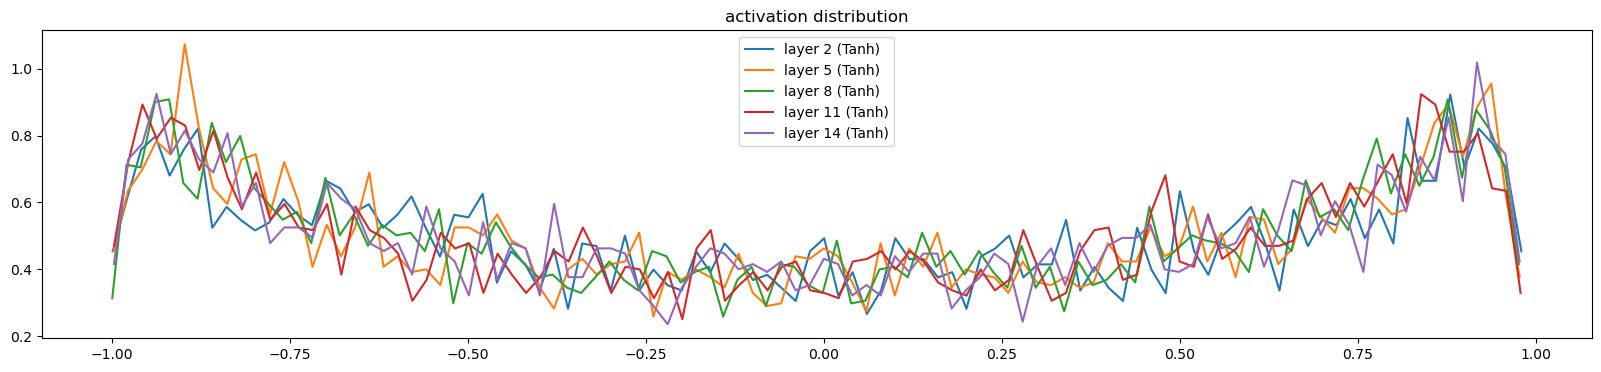

In [25]:
plt.figure(figsize=(20, 4))
legends = list()

for i, layer in enumerate(model.layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')


layer 2 (      Tanh): mean +0.000000, std 5.928575e-04
layer 5 (      Tanh): mean +0.000000, std 4.965875e-04
layer 8 (      Tanh): mean -0.000000, std 4.480190e-04
layer 11 (      Tanh): mean -0.000000, std 3.877886e-04
layer 14 (      Tanh): mean +0.000000, std 3.426718e-04


Text(0.5, 1.0, 'gradient distribution')

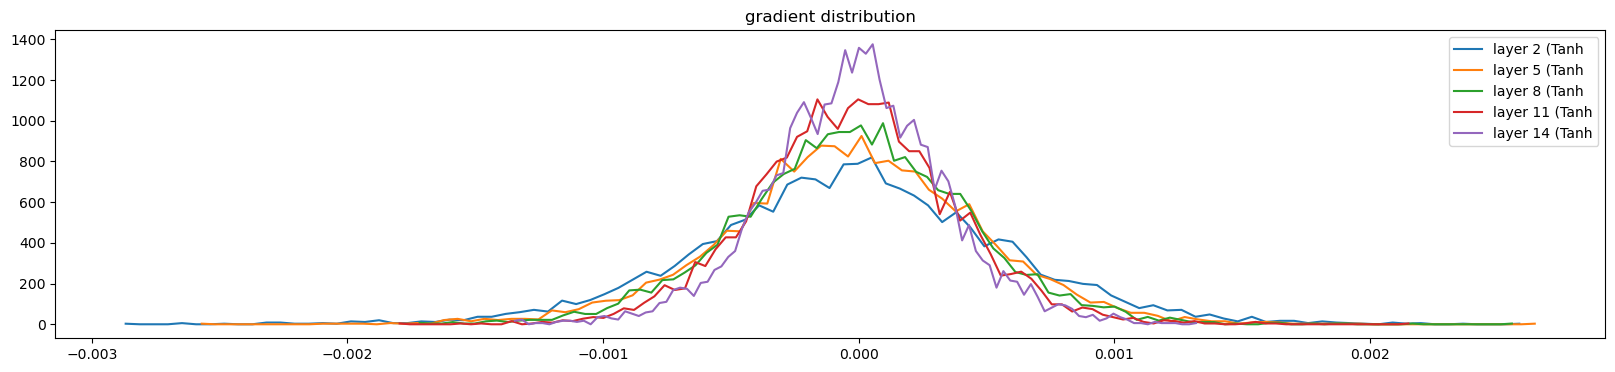

In [26]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(model.layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 1.903349e-03 | grad:data ratio 1.901972e-03
weight  (30, 200) | mean -0.000006 | std 1.310729e-03 | grad:data ratio 4.218483e-03
weight (200, 200) | mean +0.000004 | std 1.171135e-03 | grad:data ratio 9.941373e-03
weight (200, 200) | mean +0.000002 | std 1.038864e-03 | grad:data ratio 8.825935e-03
weight (200, 200) | mean +0.000003 | std 9.302532e-04 | grad:data ratio 7.861371e-03
weight (200, 200) | mean +0.000002 | std 8.129725e-04 | grad:data ratio 6.913297e-03
weight  (200, 27) | mean +0.000007 | std 1.991641e-03 | grad:data ratio 1.681360e-02


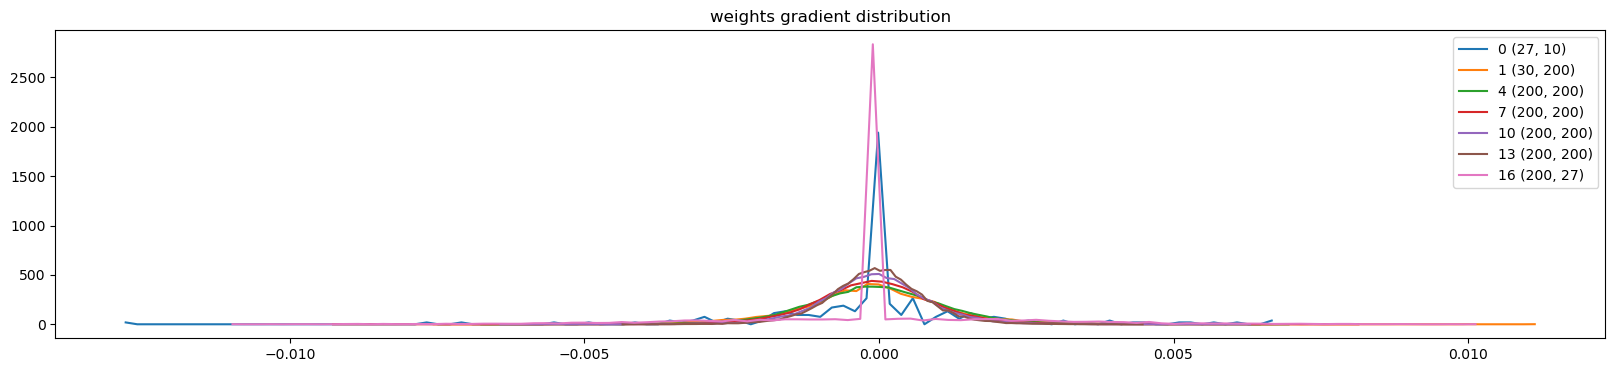

In [27]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(model.parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

Dataset size: 182761


Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Loss 2/1001: 3.292421579360962
Loss 100/1001: 2.9394850730895996
Loss 200/1001: 2.7367544174194336
Loss 300/1001: 2.65999436378479
Loss 400/1001: 2.5177931785583496
Loss 500/1001: 2.720280408859253
Loss 600/1001: 2.3480756282806396
Loss 700/1001: 2.4291348457336426
Loss 800/1001: 2.5494465827941895
Loss 900/1001: 2.339487314224243
Loss 1000/1001: 2.5106654167175293
Dataset size: 182761


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Loss 1002/1002: 2.5911457538604736
Model Final loss: 2.5911457538604736


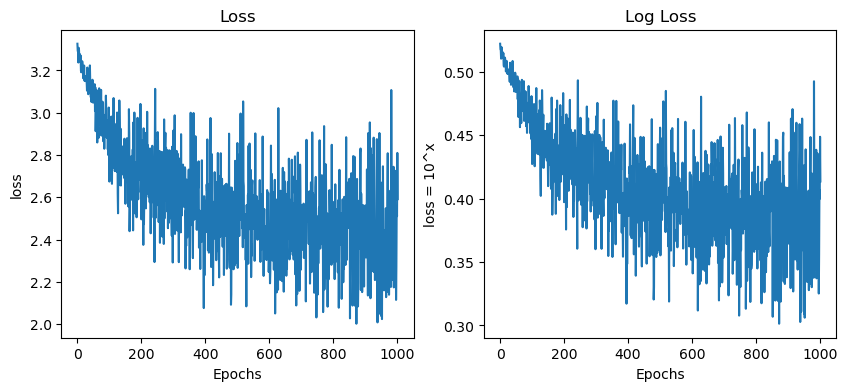

In [28]:
trainer.model.to("cuda:0")
trainer.train(x=X_train, y=Y_train, batch_size=BATCH_SIZE, epochs=1000, lrs=(0.1, 0.01), lr_decay_epoch=100_000)
trainer.model.to("cpu")
trainer.train(x=X_train, y=Y_train, batch_size=BATCH_SIZE, epochs=1, lrs=(0.1, 0.01), lr_decay_epoch=100_000)
trainer.plot()

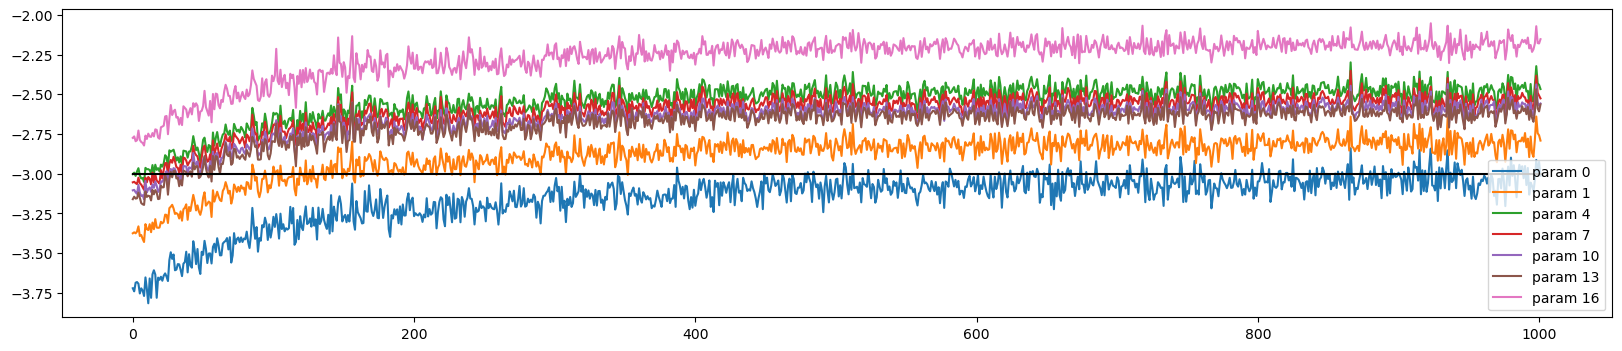

In [29]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(model.parameters):
    if p.ndim == 2:
        plt.plot([trainer.ud[j][i] for j in range(len(trainer.ud))])
        legends.append('param %d' % i)
plt.plot([0, len(trainer.ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

#### 3.2.3 Continue Training

Dataset size: 182761


Epochs:   0%|          | 0/198997 [00:00<?, ?it/s]

Loss 1003/199999: 2.417029619216919
Loss 19899/199999: 2.3368308544158936
Loss 39798/199999: 1.9240005016326904
Loss 59697/199999: 2.2117481231689453
Loss 79596/199999: 2.150235891342163
Loss 99495/199999: 2.0174083709716797
Loss 119394/199999: 2.3053793907165527
Loss 139293/199999: 2.2334749698638916
Loss 159192/199999: 1.7643073797225952
Loss 179091/199999: 2.460237503051758
Loss 198990/199999: 2.2318201065063477
Dataset size: 182761


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Loss 200000/200000: 1.9657799005508423
Model Final loss: 1.9657799005508423


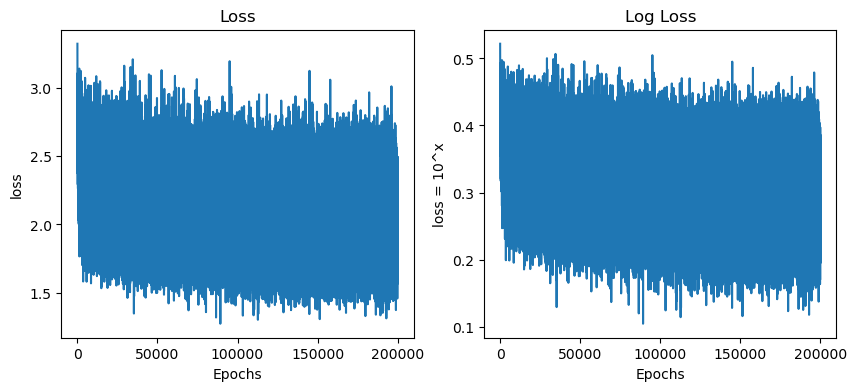

In [30]:
trainer.model.to("cuda:0")
trainer.train(x=X_train, y=Y_train, batch_size=BATCH_SIZE, epochs=198_997, lrs=(0.1, 0.01), lr_decay_epoch=100_000)
trainer.model.to("cpu")
trainer.train(x=X_train, y=Y_train, batch_size=BATCH_SIZE, epochs=1, lrs=(0.1, 0.01), lr_decay_epoch=100_000)
trainer.plot()

## 4. Evaluate

In [31]:
print(f"Train Loss: {trainer.evaluate(x=X_train, y=Y_train)}")
print(f"Val Loss: {trainer.evaluate(x=X_val, y=Y_val)}")
print(f"Test Loss: {trainer.evaluate(x=X_test, y=Y_test)}")

Train Loss: 1.9662246704101562
Val Loss: 2.088982105255127
Test Loss: 2.0771992206573486


### 5. Sampling : Name Generation

In [32]:
def gen_word_nn(model):
    ix = 0
    context = [[stoi[START]] * CONTEXT_SIZE]
    new_word = ''
    
    while True:
        _x = torch.tensor(context).to(model.device)

        # Forward
        logits = model(_x)
        probs = F.softmax(logits, dim=1)
        
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = [context[0][1:] + [ix]]
        
        if ix == 0:
            break
        new_word += itos[ix]
        
    return new_word

'fyssashlyn'

In [33]:
g = torch.Generator(device='cpu').manual_seed(4744)

new_words = list()

for _ in range(20):
    new_words.append(gen_word_nn(model=model))

new_words

['fyssashlyn',
 'elaniya',
 'soum',
 'srity',
 'kaida',
 'emani',
 'sin',
 'dan',
 'verum',
 'jani',
 'molri',
 'ten',
 'majsia',
 'ryk',
 'sai',
 'dacarlenezeiona',
 'omeroniyah',
 'reeanper',
 'calia',
 'azani']